In [31]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
class prep():
    
    def fit(self, df):
        df[["Deck", "Number", "Side"]] = df["Cabin"].str.split("/", expand = True)       
        df[["Passenger", "Group"]] = df["PassengerId"].str.split("_", expand = True)                
        
        df["Side"] = df["Side"].fillna(df.groupby("Group")["Side"].transform(lambda x: x.mode()[0]))
        df["Deck"] = df["Deck"].fillna(df.groupby("Group")["Deck"].transform(lambda x: x.mode()[0]))
        df[["CryoSleep", "HomePlanet", "VIP"]] = df[["CryoSleep", "HomePlanet", "VIP"]].fillna(df.mode().iloc[0])
        df[["CryoSleep", "VIP"]] = df[["CryoSleep", "VIP"]].astype(int)

        
        one_hot = pd.get_dummies(df["HomePlanet"], prefix = "is_")
        df_ = pd.concat([df, one_hot], axis = 1)
        df = df_.drop("HomePlanet", axis = 1)
        
        one_hot_Deck = pd.get_dummies(df["Deck"], prefix = "Deck_")
        df_ = pd.concat([df, one_hot_Deck], axis = 1)
        df = df_.drop("Deck", axis = 1)
        
        num_cols = df.select_dtypes(include =["int64", "float64"]).columns.tolist()
        df[num_cols] = df[num_cols].fillna(df[num_cols].median())
        
        
        df["Side"] = (df["Side"] == 'P').astype(int)
        df.drop(["PassengerId", "Cabin", "Name", "Destination", "Number","Group","Passenger"], axis = 1, inplace = True)
        
        
        return df
    
    
    
    

# Logistic Regression

In [6]:
class LogisticReg(BaseEstimator, ClassifierMixin):
    
    def __init__(self, alpha = 0.01, learning_rate = 1000):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.theta = None
        
    def fit(self, X, y):
        
        self.cost_list = []
        self.lr_list = []
        m = X.shape[0]
        X = np.c_[X, np.ones(X.shape[0])]
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.learning_rate):
        
            z = np.dot(X, self.theta)
            
            h_x = 1 / (1 + np.exp(-z))
            
            epsilon = 1e-10  # Small constant to prevent log(0)
            h_x = np.clip(h_x, epsilon, 1 - epsilon)


            cost = (-1/m)*np.sum(( y* np.log(h_x)) + ((1-y)*np.log(1-h_x)))

            grad = (1/m)*np.dot(X.T, (h_x - y))

            self.theta -= self.alpha* grad
            
            self.cost_list.append(cost)
            self.lr_list.append(i)
            
        return self 
            
        
    def predict(self, X):
            
        X = np.c_[X, np.ones(X.shape[0])]
        z = np.dot(X, self.theta)
        y_pred = 1/(1+np.exp(-z))
            
        return (y_pred >= 0.5)
        
        
    def get_cost_list(self):
        return self.cost_list
        
    def get_lr_list(self):
        return self.lr_list
        
        
    

In [7]:
def GridSearch(pipeline, X, y, param_grid, cv = 5):
    best_score = -np.inf
    results = []
    best_params = None
    
    kf = KFold(n_splits = cv, shuffle = True, random_state = 42)
    
    for alpha in param_grid["alpha"]:
        for learning_rate in param_grid["learning_rate"]:
            scores = []
            
            for train_index, val_index in kf.split(X):
                
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                
                
            
                pipeline.set_params(

                    model__alpha = alpha,
                    model__learning_rate = learning_rate               
                )

                pipeline.fit(X_train, y_train)

                y_pred = pipeline.predict(X_val)
                scores.append(np.mean(y_pred == y_val))

            mean_score = np.mean(scores)
            results.append((alpha, learning_rate, mean_score))

            if mean_score > best_score:
                best_score = mean_score
                best_params = {
                    "alpha" : alpha,
                    "learning_rate" : learning_rate
                }
                
    return best_score, results, best_params
            
    
    
    
    

In [8]:
param_grid = {
    "alpha": np.arange(0.001, 0.1, 0.01).tolist(),  # Learning rate step size
    "learning_rate": np.arange(500, 5000, 500).tolist()   # Number of iterations
}

In [9]:
pipeline_logistic = Pipeline([
    ('scaler', StandardScaler()),
    ("model", LogisticReg(alpha = 0.01, learning_rate = 1000))
    
])

In [10]:
pipeline_tree = Pipeline([
    ("Scalar", StandardScaler()),
    ("model", DecisionTreeClassifier(random_state = 42))
])

In [33]:
pipeline_forest = Pipeline([
    ("Scalar", StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
])

In [11]:
Prep = prep()
df = Prep.fit(df)

In [12]:
X = df.drop("Transported", axis = 1)
y = df["Transported"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 42)

In [34]:
pipeline_logistic.fit(X_train, y_train)
pipeline_tree.fit(X_train, y_train)
pipeline_forest.fit(X_train, y_train)

Pipeline(steps=[('Scalar', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [15]:
Accuracy, results, best_params = GridSearch(pipeline_logistic, X, y, param_grid, cv = 5)

In [16]:
best_params

{'alpha': 0.09099999999999998, 'learning_rate': 4500}

In [17]:
results

[(0.001, 500, 0.7499153316820971),
 (0.001, 1000, 0.7522160335788131),
 (0.001, 1500, 0.7535964017784648),
 (0.001, 2000, 0.7550917786037636),
 (0.001, 2500, 0.7557817641846729),
 (0.001, 3000, 0.7567022302276813),
 (0.001, 3500, 0.7587729810460756),
 (0.001, 4000, 0.7601534154186995),
 (0.001, 4500, 0.7615335850994349),
 (0.001, 5000, 0.7619938842939112),
 (0.001, 5500, 0.7630294251355388),
 (0.011, 500, 0.7630294251355388),
 (0.011, 1000, 0.7716565940374182),
 (0.011, 1500, 0.7759131042998535),
 (0.011, 2000, 0.7778686479736843),
 (0.011, 2500, 0.7810892865296312),
 (0.011, 3000, 0.7841952473247922),
 (0.011, 3500, 0.7845401408557885),
 (0.011, 4000, 0.7851155148488841),
 (0.011, 4500, 0.7855758140433606),
 (0.011, 5000, 0.7863810067688333),
 (0.011, 5500, 0.786380940595861),
 (0.020999999999999998, 500, 0.7711964271888861),
 (0.020999999999999998, 1000, 0.7778687141466565),
 (0.020999999999999998, 1500, 0.7826997381535492),
 (0.020999999999999998, 2000, 0.7846552818273798),
 (0.0209

In [18]:
pipeline_logistic.set_params(model__alpha = best_params["alpha"], model__learning_rate = best_params["learning_rate"])

pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticReg(alpha=0.09099999999999998, learning_rate=4500))])

In [19]:
y_pred_test = pipeline_logistic.predict(X_test)

In [20]:
accuracy_train = np.mean(y_pred_test == y_test)
accuracy_train

0.7878090856814262

In [48]:
y_pred_logistic = pipeline_logistic.predict(X_test)
y_pred_tree = pipeline_tree.predict(X_test)
y_pred_forest = pipeline_forest.predict(X_test)

# Merge predictions (e.g., majority voting)
final_pred = (y_pred_logistic  + y_pred_forest) >= 1
final_pred = final_pred.astype(int)

In [49]:
accuracy = np.mean(final_pred == y_test)
print("Ensemble Accuracy:", accuracy)

Ensemble Accuracy: 0.7872340425531915


In [50]:
accuracies = {
    'logistic': np.mean(y_pred_logistic == y_test),
    'tree': np.mean(y_pred_tree == y_test),
    'forest': np.mean(y_pred_forest == y_test)
}

best_model = max(accuracies, key=accuracies.get)
print("Best Model:", best_model)
print("Accuracies:", accuracies)

Best Model: forest
Accuracies: {'logistic': 0.7878090856814262, 'tree': 0.7377803335250144, 'forest': 0.78953421506613}


In [23]:

df_test = pd.read_csv("test.csv")

In [24]:
df_test = Prep.fit(df_test)

In [25]:
df_test

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Side,is__Earth,is__Europa,is__Mars,Deck__A,Deck__B,Deck__C,Deck__D,Deck__E,Deck__F,Deck__G,Deck__T
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0
2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,34.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0
4273,0,42.0,0,0.0,847.0,17.0,10.0,144.0,1,1,0,0,0,0,0,0,0,1,0,0
4274,1,26.0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,1,0,0,0,0
4275,0,26.0,0,0.0,2680.0,0.0,0.0,523.0,1,0,1,0,0,0,0,1,0,0,0,0


In [64]:
y_final_test_log = pipeline_logistic.predict(df_test)
y_final_test_tree = pipeline_tree.predict(df_test)

y_final_test = ((y_final_test_log))



In [65]:
y_final_test

array([ True, False,  True, ...,  True,  True,  True])

In [66]:
test_df = pd.read_csv("test.csv")

In [67]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': np.where(y_final_test, 'True', 'False')
})
submission.to_csv('submission2.csv', index=False)

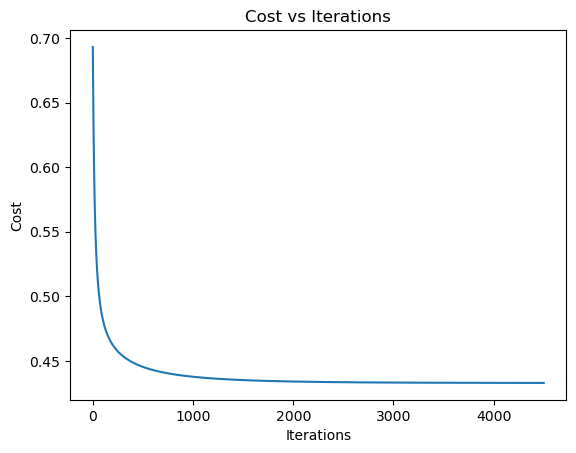

In [59]:
model = pipeline_logistic.named_steps['model']    
import matplotlib.pyplot as plt    
plt.plot(model.get_lr_list(), model.get_cost_list())     
plt.xlabel("Iterations")    
plt.ylabel("Cost")   
plt.title("Cost vs Iterations")   
plt.show()     